<a href="https://www.kaggle.com/code/sejungjenn/weratedogs-twitter?scriptVersionId=108458049" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import requests
import time
import json
!pip install tweepy
import tweepy
from PIL import Image
from io import BytesIO
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

1. Directly download weratedogs twitter archive .csv file

In [2]:
tweets = pd.read_csv("../input/weratedogs-twitter-archive-enhanced/twitter-archive-enhanced.csv")
tweets.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


2. Download the tweet image prediction .tsv file using url

In [3]:
folder = 'tweet_tsv'
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

if not os.path.exists(folder):
    os.makedirs(folder)
    
r = requests.get(url)
with open(os.path.join(folder, url.split("/")[-1]), mode='wb') as file:
    response = file.write(r.content)

In [4]:
image = pd.read_csv('./tweet_tsv/image-predictions.tsv', sep='\t')
image.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


3. Use tweepy library to query additional data via the Twitter API
(tweet_json.txt):
    * Tweepy (twitter api) allows us to mine the data of any twitter user. Using .get_status of the API class in tweepy module fetch a status(tweet)

In [ ]:
consumer_key = 'mP9YUkyksJ3gGBcmLWWNjG1HK'
consumer_secret = 'O9joKKsymUtGXMg0rsUsr4uKm3J44y5nfadefJHm3sDWBget0b'
access_token = '1577688773621694465-rWwJYImL2LRjB37xJAHr51cxSECQ9G'
access_token_secret = '9Zvzb6dNMmAe8wTI9Ppzcsv7z63aRX5MgspDP9hHJOS0M' 

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
# add `wait_on_rate_limit` parameter to automatically wait for rate limits to replenish
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(), wait_on_rate_limit=True)

In [ ]:
start_time = time.time()

# Save all JSON data of each tweet and save the queries into a 'tweet_json.txt' file 
# so that you only need to run the following long queries once.
with open ('tweet_json.txt', 'w') as file:
    for tweet_id in tweets['tweet_id']:
        try:
            # Get status/tweet for each tweet_id
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            # Convert into .json string using .dumps() function 
            # Also, add '\n' as each tweet's JSON data to be written to its own line
            file.write(json.dumps(tweet) + "\n") 
        except Exception as e:
            # if error occurs, print tweet_id and error message
            print("No tweet found for {} with error message: {}".format(str(tweet_id), str(e)))
            
end_time = time.time()
print("The process finished in {} seconds".format(end_time - start_time))

In [ ]:
# Read JSON line by line and create a python dictionary
info = []

with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        # Parse JSON encoded/formatted string line by line
        json_data = json.loads(line)
        # Create a dictionary
        info.append({'tweet_id': json_data['id'], #call the value by stating 'key'
                    'favorites': json_data['favorite_count'],
                     'retweets': json_data['retweet_count'],
                     'timestamp': json_data['created_at']
                    })

# Create a dataframe
additional = pd.DataFrame(info, columns=['tweet_id', 'favorites', 'retweets', 'timestamp'])

# Optional: Save the dataframe to .csv and add the data into this notebook.
# Doing so, you don't have to use twitter api everytime you reboot this notebook, which takes a significant amount of time. 
# additional.to_csv('additional.csv', index=False)

In [5]:
additional = pd.read_csv("../input/weratedogs-twitter-apicsv/additional.csv")
additional.head(1)

,tweet_id,favorites,retweets,timestamp
0,892420643555336193,33594,6950,Tue Aug 01 16:23:56 +0000 2017


_self-study note:_ <br>
`.dump` / `.dumps`: python to json
> * .dump() to write Python serialised object as JSON formattted data into a file
> * .dumps() to encode any Python object into JSON formatted string

`.load` / `loads`: json to python <br>
> * Use .json.load() to parse JSON URL or file
> * Use .json.loads() to parse JSON string 

# Assessing Data

In [6]:
# To see all rows in collapsed output, use the code below
pd.options.display.max_rows = None

### Quality issues
##### tweets
1. Drop retweets rows as they have no pictures (for all tables). We only want to analyse original tweets with pictures
2. More rows than image table (indicating there are tweets without pictures)
3. Non-name values in `name` column (e.g. None, very, a)
4. Unnecessary +0000 in `timestamp` column

##### image_predict
1. Inconsistencies in upper/lowercase in `p1`, `p2`, `p3` 
2. Inconsistencies in upper/lowercase in `dog_breed` column that will be created later
3. Inconsistencies in the length of decimal numbers: `p1_conf`, `p2_conf`, `p3_conf`

##### additional
1. `rating_denominator` should be 10

### Tidiness issues 
##### tweets table
1. Unnecessary columns that could be joined into one `stage` column with possible values of doggo, floofer, pupper, or puppo
2. Unnecessary columns with too many null values: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`,`retweeted_status_user_id`,`retweeted_status_timestamp`.
3. Wrong datatypes `tweet_id`, `timestamp`  

##### image table
1. A column needed for dog breed predicted True
2. Wrong datatype `tweet_id`

##### additional table
1. Wrong data types of `tweet_id`, `timestamp` columns. Ignore `timestamp` for now as we will drop the column later.
2. Duplicate `timestamp` information in both df1 and df2 datasets

In [7]:
# Before any cleaning, make a copy of original datasets.
tweets_clean = tweets.copy()
image_clean = image.copy()
add_clean = additional.copy()

##### Clean 1 (all tables)
Define: 
- Drop retweet cases

Code 1: merge tables

In [8]:
# Merge `text` column to image and additional table on='tweet_id'.
# To do so, first, create a temporary table with an identifier column `tweet_id` and `text`.
texts = tweets_clean[['tweet_id', 'text']]

# Merge
image_clean = pd.merge(image_clean, texts, on='tweet_id')
add_clean = pd.merge(add_clean, texts, on='tweet_id')

# Confirm
image_clean.columns, add_clean.columns

(Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
        'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'text'],
       dtype='object'),
 Index(['tweet_id', 'favorites', 'retweets', 'timestamp', 'text'], dtype='object'))

Code 2: remove retweets

In [9]:
# First, define a function that returns a mask of retweet entries.
def retweet_mask(table):
    mask = table.text.str.contains("RT")
    return mask

# Drop retweet rows using the function.
tweets_clean = tweets_clean[~retweet_mask(tweets_clean)]
image_clean = image_clean[~retweet_mask(image_clean)]
add_clean = add_clean[~retweet_mask(add_clean)]

In [10]:
# Confirm if there is any RT left in tables. You should get False's.
print(tweets_clean[tweets_clean['text'].str.contains('RT')].sum().any()),
print(image_clean[image_clean['text'].str.contains('RT')].sum().any()),
print(add_clean[add_clean['text'].str.contains('RT')].sum().any())

False
False
False


In [11]:
# Once it is confirmed, drop the redudant `text` columns from previously merged tables.
image_clean.drop('text', axis=1, inplace=True)
add_clean.drop('text', axis=1, inplace=True)

# Confirm. Column `text` should not be included in a duplicated series.
all_col = pd.Series(list(tweets_clean) + list(image_clean) + list(add_clean))
all_col[all_col.duplicated()]

17     tweet_id
29     tweet_id
32    timestamp
dtype: object

##### Clean 2 (all tables) 
Define: 
- More rows than image (indicating there are tweets without pictures) 

Code 1:

In [12]:
# Extract `tweet_id` from image_clean and make it into a list
id_list = list(image_clean.tweet_id)

# Then, query only the rows with `tweet_id` in image_clean table.
tweets_clean = tweets_clean[tweets_clean['tweet_id'].isin(id_list)]
add_clean = add_clean[add_clean['tweet_id'].isin(id_list)]

# If you want to replace the two above lines with a defined function, use below code.
# def id_select(table, varName='tweet_id'): # arguments with '=' are set as a default
    # table = table[table[varName]].isin(id_list)
    # return table

In [13]:
# Confirm with boolean statement. You should get two True's
print(tweets_clean.tweet_id.isin(image_clean.tweet_id).sum().any()),
print(add_clean.tweet_id.isin(image_clean.tweet_id).sum().any())

True
True


> self-study note: <br>

when creating a function,
1. Avoid using actual dataframe names in your function - the placeholder can be replaced with an actual dataframe name later (and python can actually use global variables inside functions, so it is error prone)
2. Including optional arguments, like varName, allows you to use the function for different columns while, at the same time, using the default when you call the function.
3. Using a return statement allows you to use a different dataframe name for the result. This avoids over-writing already existing dataframes.

##### Clean 3 (tweets_clean)
Define:
Drop unnecessary columns with too many null values

Code:

In [14]:
# Make a list of columns to drop
drop_cols = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp']

# Drop
tweets_clean.drop(columns = drop_cols, inplace=True)

# Confirm
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            1986 non-null   int64 
 1   timestamp           1986 non-null   object
 2   source              1986 non-null   object
 3   text                1986 non-null   object
 4   expanded_urls       1986 non-null   object
 5   rating_numerator    1986 non-null   int64 
 6   rating_denominator  1986 non-null   int64 
 7   name                1986 non-null   object
 8   doggo               1986 non-null   object
 9   floofer             1986 non-null   object
 10  pupper              1986 non-null   object
 11  puppo               1986 non-null   object
dtypes: int64(3), object(9)
memory usage: 201.7+ KB


##### Clean 4 (tweets_clean)
Define:
Drop duplicated columns

Code:

In [15]:
# Look for duplicated columns
all_cols = pd.Series(list(tweets_clean) + list(image_clean) + list(add_clean))
all_cols[all_cols.duplicated()]

12     tweet_id
24     tweet_id
27    timestamp
dtype: object

In [16]:
# Drop `timestamp` column from `add_clean` table as it is irrelevant to table's observational unit
add_clean.drop('timestamp', axis=1, inplace=True)

# Confirm
add_clean.columns

Index(['tweet_id', 'favorites', 'retweets'], dtype='object')

##### Clean 5 (tweets_clean)
Define: 
Join redundant columns into `stage` column with possible values of doggo, floofer, pupper, or puppo

Code:

In [17]:
# By running the code below, you can see that "None" string value is included–other than empty space or actual stage–in the column value.
print("doggo: {}, floofer: {}, puppo: {}, pupper:{}"
     .format(tweets_clean.doggo.unique(), 
            tweets_clean.floofer.unique(),
            tweets_clean.puppo.unique(),
            tweets_clean.pupper.unique()))

doggo: ['None' 'doggo'], floofer: ['None' 'floofer'], puppo: ['None' 'puppo'], pupper:['None' 'pupper']


In [18]:
# So before joining the four columns, first replace "None" to empty-space "".
# Then join the columns.
# Some columns for example will be "   floofer ", reflecting empty spaces created by joining the columns. So strip those empty spaces.
tweets_clean['stage'] = (tweets_clean[['doggo', 'floofer', 'puppo', 'pupper']]
                         .replace("None","").apply(lambda x: " ".join(x), axis=1).str.strip())

# Confirm if merge successful.
tweets_clean.query("stage != ''").sample(4)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage
724,782747134529531904,2016-10-03 01:00:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Deacon. He's the happiest almost dry d...,https://twitter.com/dog_rates/status/782747134...,11,10,Deacon,doggo,None,None,None,doggo
1103,735256018284875776,2016-05-24 23:47:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kellogg. He accidentally opened the fr...,https://twitter.com/dog_rates/status/735256018...,8,10,Kellogg,doggo,None,None,None,doggo
1825,676470639084101634,2015-12-14 18:35:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Three generations of pupper. 11/10 for all htt...,https://twitter.com/dog_rates/status/676470639...,11,10,None,None,None,pupper,None,pupper
129,867421006826221569,2017-05-24 16:44:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Shikha. She just watched you drop a sk...,https://twitter.com/dog_rates/status/867421006...,12,10,Shikha,None,None,None,puppo,puppo


In [19]:
# Drop the redundant columns
tweets_clean.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

# Confirm
tweets_clean.dtypes

tweet_id               int64
timestamp             object
source                object
text                  object
expanded_urls         object
rating_numerator       int64
rating_denominator     int64
name                  object
stage                 object
dtype: object

##### Clean 6 (all tables)
Define: 
- Convert wrong datatypes

Code:

In [20]:
# Before changing datatypes, remove +0000 from `timestamp` column
tweets_clean['timestamp'] = tweets_clean['timestamp'].str[:-5]
tweets_clean.timestamp[:5]

0    2017-08-01 16:23:56 
1    2017-08-01 00:17:27 
2    2017-07-31 00:18:03 
3    2017-07-30 15:58:51 
4    2017-07-29 16:00:24 
Name: timestamp, dtype: object

In [21]:
# Create a function that converts wrong datatypes with input arguments (table)
def change_dtypes(table):
    for col in table.columns:
        if col[-3:] == "_id":
            table[col] = table[col].astype(str)
        elif col[-5:] == "stamp":
            table[col] = pd.to_datetime(table[col])
        else:
            table[col] = table[col]
            
# Call the function
change_dtypes(tweets_clean)
change_dtypes(image_clean)
change_dtypes(add_clean)

In [22]:
# Confirm
tweets_clean.dtypes, image_clean.dtypes, add_clean.dtypes

(tweet_id                      object
 timestamp             datetime64[ns]
 source                        object
 text                          object
 expanded_urls                 object
 rating_numerator               int64
 rating_denominator             int64
 name                          object
 stage                         object
 dtype: object,
 tweet_id     object
 jpg_url      object
 img_num       int64
 p1           object
 p1_conf     float64
 p1_dog         bool
 p2           object
 p2_conf     float64
 p2_dog         bool
 p3           object
 p3_conf     float64
 p3_dog         bool
 dtype: object,
 tweet_id     object
 favorites     int64
 retweets      int64
 dtype: object)

##### Clean 7 (image_clean)
Define: 
- Create an new column for predicted breed of a dog.

Code:
- np.where(condition, value if condition True, value if condition False)
- Since the prediction p1, p2, p3 is hierarchical, if the first prediction is True (i.e. is a dog), that is the prediction you want. If False (i.e. not a dog), move onto the second prediction
- `px_dog` is vectorised, so you can just use the column itself as a condition in np.where() 

In [23]:
image_clean['dog_breed'] = np.where(image_clean['p1_dog'], image_clean['p1'],# condition, value if True
                                   np.where(image_clean['p2_dog'], image_clean['p2'],# value if False
                                           np.where(image_clean['p3_dog'], image_clean['p3'],
                                           np.nan)))

In [24]:
# Confirm
image_clean.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_breed
629,680913438424612864,https://pbs.twimg.com/media/CXMXKKHUMAA1QN3.jpg,1,Pomeranian,0.615678,True,golden_retriever,0.126455,True,Chihuahua,0.087184,True,Pomeranian
854,696488710901260288,https://pbs.twimg.com/media/CapsyfkWcAQ41uC.jpg,1,briard,0.369063,True,Scotch_terrier,0.168204,True,giant_schnauzer,0.120553,True,briard
985,707610948723478529,https://pbs.twimg.com/media/CdHwZd0VIAA4792.jpg,1,golden_retriever,0.383223,True,cocker_spaniel,0.165930,True,Chesapeake_Bay_retriever,0.118199,True,golden_retriever


##### Clean 8 (image_clean)
Define: 
- Lowercase all breed values in `p1`, `p2`, `p3`, `dog_breed` columns
- Lowercase `dog_breed` column 
- Standardise the length of decimal numbers in `p1_conf`, `p2_conf`, `p3_conf`: .round()

Code 1:

In [25]:
# Lowercase
def lowercase(table):
    breed_cols = ['p1', 'p2', 'p3', 'dog_breed']
    for c in table.columns:
        if c in breed_cols:
            table[c] = table[c].str.lower()

# Call the function
lowercase(image_clean)

# Confirm
image_clean.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_breed
1167,735648611367784448,https://pbs.twimg.com/media/CjWMezdW0AErwU3.jpg,1,pembroke,0.462594,True,seat_belt,0.261854,False,cardigan,0.151698,True,pembroke
694,684241637099323392,https://pbs.twimg.com/media/CX7qIcdWcAELJ7N.jpg,1,pembroke,0.508498,True,black-footed_ferret,0.115532,False,weasel,0.051280,False,pembroke
1160,734776360183431168,https://pbs.twimg.com/media/CjJzMlBUoAADMLx.jpg,1,siberian_husky,0.304902,True,eskimo_dog,0.155147,True,malamute,0.050942,True,siberian_husky


Code 2:

In [26]:
# Round decimal numbers
for c in image_clean.columns:
    if c[-4:] == "conf":
        image_clean[c] = image_clean[c].round(3)

# Confirm
image_clean.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465,True,collie,0.157,True,shetland_sheepdog,0.061,True,welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.507,True,miniature_pinscher,0.074,True,rhodesian_ridgeback,0.072,True,redbone


##### Clean 9 (add_clean)
Define: 
- Replace invalid rating_denominator with 10

Code:

In [27]:
# Create a mask for`rating_denominator` value other than 10.
denom_mask = tweets_clean['rating_denominator'] != 10

# Then assign the value of 10 to those wrong entries.
tweets_clean.loc[denom_mask, 'rating_denominator'] = 10

# Confirm
tweets_clean.query('rating_denominator != 10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage


##### Clean 10 (tweets_clean) 
Define: 
- Replace non-name values (e.g. None, very) to Nan 

Code:

In [28]:
# Create a list of invalid names found.
non_name = ['None', 'very', 'incredibly', 'his', 'just', 'getting', 'mad', 'this', 'unacceptable', 'all', 
            'old', 'by', 'life', 'light', 'space', 'a']
        
# Convert
tweets_clean.loc[tweets_clean['name'].isin(non_name), 'name'] = np.nan

# Confirm. It should return empy series.
tweets_clean.loc[tweets_clean['name'].isin(non_name), 'name']

Series([], Name: name, dtype: object)

#### Store cleaned data

In [29]:
tweets_clean.to_csv("twitter_archive_master.csv", index=False)
image_clean.to_csv("image_prediction.csv", index=False)
add_clean.to_csv("twitter_api.csv", index=False)

# Wrangling report
In this section, explain your wrangling efforts (300-600).

# Visualisation & Report
In this section, visualise and communicate insights with visualisations. The insights are as follows:
1. What time of the day gets higher likes / retweets. Is there any correlation between time of the day and like count? This insight might be useful for people who want to grow their dog tweet's audience.

2. What types of words do twitter users choose to describe specific breeds? What kind of terms are used when people describe the top 3 breeds with highest like counts.

3. 

In [30]:
# Merge all datasets for choosing appropriate columns for each analysis.
all_df = pd.merge(tweets_clean, image_clean, on='tweet_id')
all_df = pd.merge(all_df, add_clean, on='tweet_id')

#### 1. Time Series
We will look into any possible trend in the weratedogs tweets.

##### Result 1. Time vs. Likes / Retweets

In [ ]:
# Create a dataset for first analysis & visualisation
time_df = all_df[['tweet_id', 'timestamp', 'favorites', 'retweets']]

# Create a new column for time(hourly-based) of the day
time_df['hour'] = time_df['timestamp'].dt.hour

# Confirm
time_df.head(1)

In [ ]:
# Get the like / retweet counts by hour
likes_by_hour = time_df.groupby('hour')['favorites'].sum()
retweet_by_hour = time_df.groupby('hour')['retweets'].sum()

In [ ]:
# Visualise
fig, ax = plt.subplots(1, 2, figsize=(12,5))
# Use padding to adjust spacing between subplots
fig.tight_layout(pad=5.0)

# Create a plot for time vs. like counts
plt.subplot(1,2,1)
sns.regplot(data=likes_by_hour, x=likes_by_hour.index, y=likes_by_hour.values)
plt.xlabel('time of the day (hours)')
plt.ylabel('like counts')
# Disable scientific notation of number (1e6 to normal number)
ax[0].ticklabel_format(useOffset=False, style='plain')

# Create a plot for time vs. retweet counts
plt.subplot(1,2,2)
sns.regplot(data=retweet_by_hour, x=retweet_by_hour.index, y=retweet_by_hour.values)
plt.xlabel('time of the day (hours)')
plt.ylabel('retweet counts')

plt.savefig('Time vs Likes & Retweets.png', format='png');

#### 2. Word Cloud for Top 3 Breeds

In [196]:
# Get a separate table for dog breed and favourite/retweet counts
breed_liked = all_df[['dog_breed', 'favorites', 'retweets', 'text']]

# Get top 3 liked dog breeds
breed_liked.groupby('dog_breed')['favorites'].sum().sort_values(ascending=False).head(3)

dog_breed
golden_retriever      1672129
labrador_retriever    1032193
pembroke               899706
Name: favorites, dtype: int64

In [197]:
folder_name = 'dog_image'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
breed_list = ['Labrador_Retriever', 'Golden_Retriever', 'Pembroke_Welsh_Corgi']

for breed in breed_list:
    try:
        first_image = wptools.page(breed, silent=True).get().data['image'][0]
        first_image_url = first_image['url']
        r = requests.get(first_image_url)
        i = Image.open(BytesIO(r.content))
        file_format = first_image_url.split(".")[-1]
        # save
        i.save(folder_name + "/" + breed + "." + file_format)
    except Exception as e:
        print(breed + ":" + str(e))        

Labrador_Retriever:name 'wptools' is not defined
Golden_Retriever:name 'wptools' is not defined
Pembroke_Welsh_Corgi:name 'wptools' is not defined


In [198]:
# Make lists for image_urls and top 3 breeds
image_urls = ['https://media.istockphoto.com/vectors/dog-labrador-retriever-breed-silhouette-vector-id1092723256?k=20&m=1092723256&s=612x612&w=0&h=qySoeV2lvEq0_5dulzZrdWFlAc3nMQPPGma6RBgrBHg=', 
      'https://t4.ftcdn.net/jpg/01/88/70/41/360_F_188704170_u9F3xra8zpaevTJxIAjqN8vZPW3DxLJi.jpg',
      'https://i.etsystatic.com/6643643/r/il/dc7011/734909679/il_570xN.734909679_mgc2.jpg']
breeds = ['labrador_retriever', 'golden_retriever', 'pembroke']

# Create a list of image mask for each breed
image_list = []
for url in image_urls:
    '''Get silhouette image for each breed from the internet, 
    and return image mask with numpy array'''
    # Get image from internet
    r = requests.get(url)
    image = Image.open(BytesIO(r.content))
    # Use numpy to mask an image
    image_mask = np.array(image)
    image_list.append(image_mask)
    
# Create a list of whole text for each breed's tweets
text_list = []
for breed in breeds:
    '''Get the whole tweeted text for each breed'''
    # Create mask for each top 3 breed
    text_mask = breed_liked['dog_breed'] == breed
    whole_text = "".join(breed_liked.loc[text_mask, 'text'])
    text_list.append(whole_text)

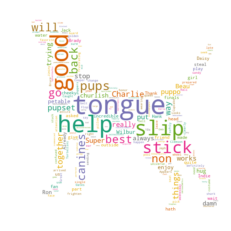

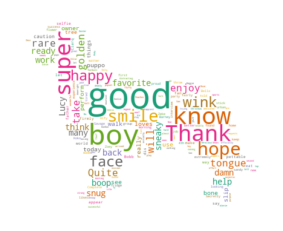

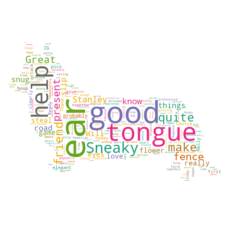

In [199]:
# Make a list of stopwords
stopwords = ['https', 'co', 't', 'dog', 'af', 'hello', 'want', 'look',
            'pupper', 'doggo', 'dogs', 'pet', 'got', 'ckin', 'h', 'much'
            ,'still', 'please', 'well', 'day', 'time', 'wants', 'pup', 'tho',
            'amp', 'send', 'rate', 'one', 'now', 'Sadie', 'never', 'rather', 'someone', 'even', 'hat', 'ck', 'seems', 'thing'] + list(STOPWORDS)

# Word cloud
for breed, image, text in zip(breeds, image_list, text_list):
    '''Create word cloud for each breed'''
    wordcloud = WordCloud(collocations=False, background_color='white', mask = image, stopwords=stopwords, colormap='Dark2').generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    # Save wordcloud image for each breed
    plt.savefig(breed + '.png', format='png')
    continue;

#### 3. Time series trend

In [31]:
time_series = all_df[['timestamp', 'favorites', 'retweets']]
time_series.head(1)

,timestamp,favorites,retweets
0,2017-08-01 16:23:56,33594,6950


In [32]:
time_series['date'] = pd.to_datetime(time_series['timestamp']).dt.date

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
time_series['date'] = pd.to_datetime(time_series['date'])
time_series.dtypes

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


timestamp    datetime64[ns]
favorites             int64
retweets              int64
date         datetime64[ns]
dtype: object

In [35]:
time_series.head(1)

,timestamp,favorites,retweets,date
0,2017-08-01 16:23:56,33594,6950,2017-08-01


In [36]:
time_series = time_series.set_index('date').drop(columns = 'timestamp')
time_series.index

DatetimeIndex(['2017-08-01', '2017-08-01', '2017-07-31', '2017-07-30',
               '2017-07-29', '2017-07-29', '2017-07-28', '2017-07-28',
               '2017-07-27', '2017-07-26',
               ...
               '2015-11-16', '2015-11-16', '2015-11-16', '2015-11-16',
               '2015-11-16', '2015-11-16', '2015-11-16', '2015-11-15',
               '2015-11-15', '2015-11-15'],
              dtype='datetime64[ns]', name='date', length=1978, freq=None)

In [61]:
data_cols = ['favorites', 'retweets']
monthly_means = time_series[data_cols].resample('M').mean()

In [58]:
time_series.index.max()

Timestamp('2017-08-01 00:00:00')

### The channel audience is growing overall basing on the growing like & retweet counts

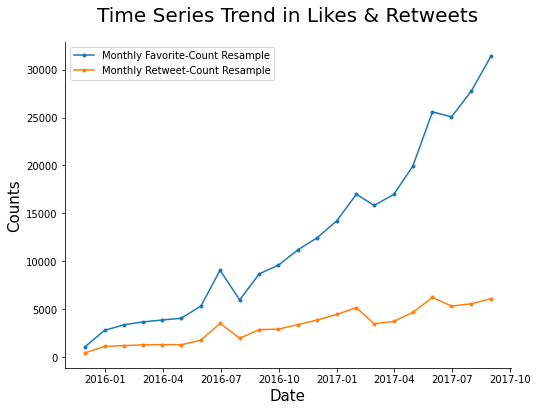

In [201]:
fig, ax = plt.subplots(figsize=(8,6))

#ax.plot(time_series.loc[:, data_cols], marker='.', linestyle='-',linewidth=0.5, label='Daily')

ax.plot(monthly_means.loc[:, 'favorites'], marker='o', markersize=3, linestyle='-', label='Monthly Favorite-Count Resample')
ax.plot(monthly_means.loc[:, 'retweets'], marker='o', markersize=3, linestyle='-', label='Monthly Retweet-Count Resample')
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('Date', fontsize=15)
ax.legend()
ax.set_title("Time Series Trend in Likes & Retweets", pad=20, fontsize=20)
sns.despine() # remove top and right spines from plot;

# Let's look at montly trend with box plot. Seasonality.

In [64]:
time_series['month'] = time_series.index.month

In [66]:
time_series.dtypes

favorites    int64
retweets     int64
month        int64
dtype: object

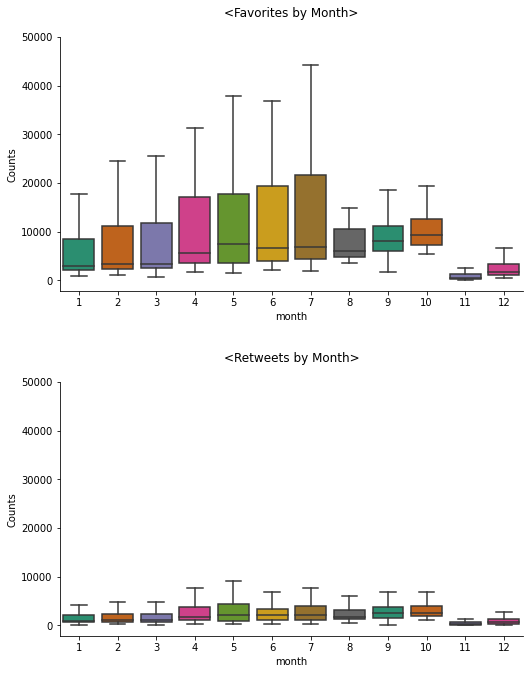

In [203]:
# Group the data by month, to visualise yearly seasonality.
fig, axes = plt.subplots(2,1, figsize=(8,10), sharex=False, sharey=True)

for data_col, ax in zip(['favorites', 'retweets'], axes):
    sns.boxplot(data=time_series, x='month', y=data_col, ax=ax, palette='Dark2', 
                showfliers = False) # remove outlier dots
    ax.set_ylabel('Counts')
    ax.set_title("<" + data_col.capitalize() + " by Month>", pad=20, fontsize=12)
    ax.set_ylim(top=50000)
    sns.despine()
    fig.tight_layout(pad=3.0);

In [83]:
time_series['weekday_name'] = time_series.index.strftime('%A')

In [90]:
time_series.sample(3)

,favorites,retweets,month,weekday,weekday_name
date,,,,,
2016-04-04,2967,865,4,Monday,Monday
2015-12-16,3188,1451,12,Wednesday,Wednesday
2016-01-15,1587,320,1,Friday,Friday


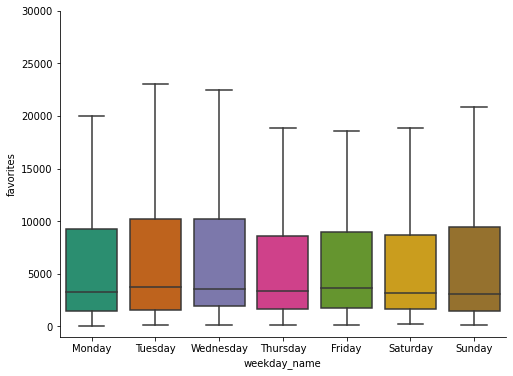

In [205]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(8,6))
plt.ylim(-1000,30000)
sns.boxplot(data=time_series, x='weekday_name', y='favorites', order=day_order, palette='Dark2', showfliers = False)
sns.despine();

_self-study note:_
* np.r_ to select non-consecutive rows/columns <br>
e.g. tweets_clean.columns[np.r_[0, 10:15]] <br>
tweets_clean.iloc[: , np.r_[0, 10:15]]
